# 01 Data exploration

The goal of this notebook is to provide an insight on the future sales datasets in order to have a better understanding of the data they contain, and to generate naive predictions based on average counts.

## Reading data

We read the datasets from the csv files.

In [268]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

train_data = pd.read_csv('data/sales_train.csv')
test_data = pd.read_csv('data/test.csv')

train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


We convert the date into a datetime object.

In [269]:
train_data['date'] = pd.to_datetime(train_data['date'], format="%d.%m.%Y")

train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


## Exploration

We may now explore the data. For instance, we can check that it contains no missing values.

In [270]:
pd.isna(train_data).any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

And we can also check the ranges for each of the values. Here we see the following:
- The data goes from Jan 1st 2013 to Oct 31st 2015
- Each of the 34 months is indexed by an integer from 0 to 33
- The 60 shops are indexed by integers from 0 to 59
- The 22170 items are indexed by integers from 0 to 22169
- The item price can be negative
- The daily item count can also be negative

In [271]:
pd.concat([train_data.min().rename('min'), train_data.max().rename('max')], axis=1)

,min,max
date,2013-01-01 00:00:00,2015-10-31 00:00:00
date_block_num,0,33
shop_id,0,59
item_id,0,22169
item_price,-1.0,307980.0
item_cnt_day,-22.0,2169.0


We can also take a look at the most typical values, for example we find the most popular shop and item.

In [272]:
modes = train_data.mode()

typical_shop_id = modes['shop_id'][0]
typical_item_id = modes['item_id'][0]

modes

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-12-28,11,31,20949,299.0,1.0


## Average count prediction

As a first naive guess, we are going to submit the average month counts for each shop and item.

We start by defining a helper function to aggregate the data.

In [273]:
def aggregate(data, group_fields, agg_field, rename=''):
    agg_data = data.groupby(group_fields, as_index=False)[agg_field].sum()

    if rename:
        agg_data = agg_data.rename(columns={agg_field: rename})

    return agg_data

 In order to validate our predictions, we split the train dataset into the first months and the last one.

In [274]:
# Number of months in the training dataset
n_months = 33

# Split dataset into training and validation
last_month = train_data[train_data['date_block_num'] == n_months]
first_months = train_data[train_data['date_block_num'] < n_months]

first_months.shape, last_month.shape

((2882335, 6), (53514, 6))

Now we aggregate the data by adding up all the daily item counts over each month. We do so using the helper function we defined above.

In [275]:
# Aggregate datasets per month
first_agg_month = aggregate(first_months, ['shop_id', 'item_id', 'date_block_num'], 'item_cnt_day', 'item_cnt_month')
last_agg_month = aggregate(last_month, ['shop_id', 'item_id', 'date_block_num'], 'item_cnt_day', 'item_cnt_month')

first_agg_month.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


Next we further aggregate the data by averaging the item counts over all months.

In [276]:
# Compute the average item counts over the first months
first_agg_all_time = aggregate(first_agg_month, ['shop_id', 'item_id'], 'item_cnt_month', 'item_cnt_all_time')
first_agg_all_time['item_avg'] = first_agg_all_time['item_cnt_all_time'] / n_months

first_agg_all_time.head()

,shop_id,item_id,item_cnt_all_time,item_avg
0,0,30,31.0,0.939394
1,0,31,11.0,0.333333
2,0,32,16.0,0.484848
3,0,33,6.0,0.181818
4,0,35,15.0,0.454545


And we finally put together in the same dataframe our predictions with the ground truth.

In [278]:
predictions = pd.merge(first_agg_all_time[['shop_id', 'item_id', 'item_avg']], last_agg_month[['shop_id', 'item_id','item_cnt_month']], on=['shop_id', 'item_id'], how='left').rename(columns={'item_cnt_month': 'true_item_cnt'}).fillna(0)

# Compute the squared error
predictions['se'] = (predictions['item_avg'] - predictions['true_item_cnt'])**2

predictions.head()

,shop_id,item_id,item_avg,true_item_cnt,se
0,0,30,0.939394,0.0,0.882461
1,0,31,0.333333,0.0,0.111111
2,0,32,0.484848,0.0,0.235078
3,0,33,0.181818,0.0,0.033058
4,0,35,0.454545,0.0,0.206612


The rooted mean square error is the metric we are considering for the error. Its value is rather high, this is due to the naive approach for the predictions.

In [279]:
# Compute the rooted mean squared error
rmse = np.sqrt(predictions['se'].mean())

rmse

3.5957456956230414

## Visualization

We can plot some examples to better understand the nature of the errors we are making. The following is a helper function which allows us to plot the evolution over time of an item's sales in a given shop, also with its predicted value for the next month.

In [281]:
def plot_shop_item(data, shop_id, item_id, pred):
    shop_item_data = data[(data['shop_id'] == shop_id) & (data['item_id'] == item_id)].sort_values(by='date_block_num')

    christmas = [11, 23]

    fig, ax = plt.subplots(figsize=(12, 6))
    [ax.axvline(x=n, linewidth=1, color='tab:red') for n in christmas]
    ax.axhline(y=pred, linewidth=1, color='tab:green')
    ax.plot(shop_item_data['date_block_num'], shop_item_data['item_cnt_month'], color='tab:blue', marker='o')

Let us check a few examples. The vertical red lines mark Christmas.

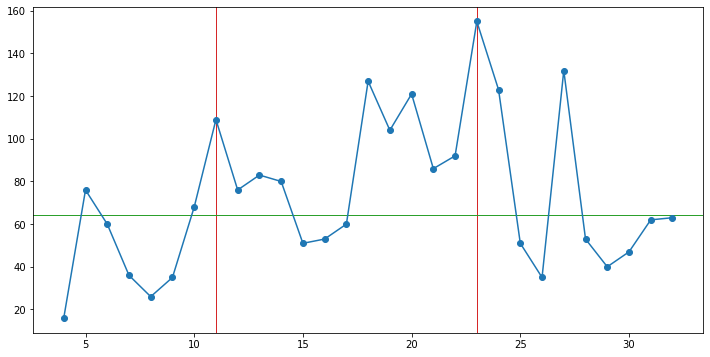

In [286]:
shop_id = 5
item_id = 20949
pred = predictions['item_avg'][(predictions['shop_id'] == shop_id) & (predictions['item_id'] == item_id)].iloc[0]

plot_shop_item(first_agg_month, shop_id, item_id, pred)

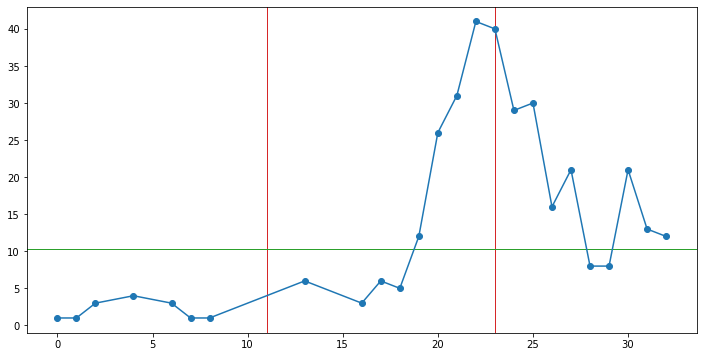

In [287]:
shop_id = 53
item_id = 17717
pred = predictions['item_avg'][(predictions['shop_id'] == shop_id) & (predictions['item_id'] == item_id)].iloc[0]

plot_shop_item(first_agg_month, shop_id, item_id, pred)

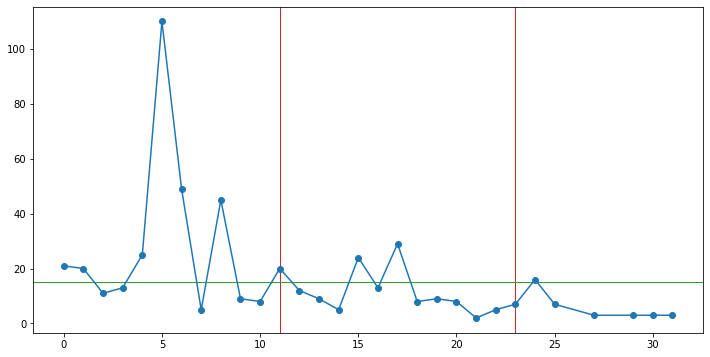

In [289]:
shop_id = 42
item_id = 2808
pred = predictions['item_avg'][(predictions['shop_id'] == shop_id) & (predictions['item_id'] == item_id)].iloc[0]

plot_shop_item(first_agg_month, shop_id, item_id, pred)

In this last example we see how the monthly average is not a very good estimate, as it gives every month the same weight, and we do not capture increasing or decreasing popularity.

## Submission

We are now ready to submit our predictions. First we need to repeat the aggregation process for the whole dataset, this time without excluding the last month for validation.

In [291]:
# Repeat for the whole dataset
agg_month = aggregate(train_data, ['shop_id', 'item_id', 'date_block_num'], 'item_cnt_day', 'item_cnt_month')

n_months = 34

agg_all_time = aggregate(agg_month, ['shop_id', 'item_id'], 'item_cnt_month', 'item_cnt_all_time')
agg_all_time['item_avg'] = agg_all_time['item_cnt_all_time'] / n_months

agg_all_time.head()

,shop_id,item_id,item_cnt_all_time,item_avg
0,0,30,31.0,0.911765
1,0,31,11.0,0.323529
2,0,32,16.0,0.470588
3,0,33,6.0,0.176471
4,0,35,15.0,0.441176


We finally generate the csv file ready for submission.

In [292]:
def generate_submission_file(data, pred_field, filename='submission.csv'):
    predictions = pd.merge(test_data, data, on=['shop_id', 'item_id'], how='left').fillna(0)

    output = pd.DataFrame({'ID': predictions['ID'], 'item_cnt_month': predictions[pred_field]})
    output.to_csv('predictions/' + filename, index=False)
    print("Submission successfully saved!")

In [294]:
generate_submission_file(agg_all_time, 'item_avg')

Submission successfully saved!
